# Loan Defaulters Prediction

### Classification with Python</font></h1>

In this notebook we predict loan defaulters using following algorithms and **find the best one for this specific dataset by accuracy evaluation methods.**

**Algorithms used:**

**1. K Nearest Neighbours**

**2. Decision Tree**

**3. Support Vector Machine**

**4. Logistic Regression**


Lets first load required libraries:

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset

This dataset is about past loans. The __Loan_train.csv__ data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |

Lets download the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-04-28 09:46:03--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.07s   

2021-04-28 09:46:04 (304 KB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File  

In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object 

In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing



Let’s see how many of each class is in our data set 

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection 


Lets plot some columns to underestand data better:

In [7]:
# notice: installing seaborn might takes a few minutes
#!conda install -c anaconda seaborn -y

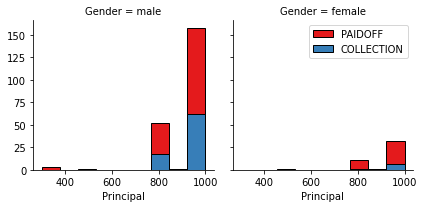

In [8]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

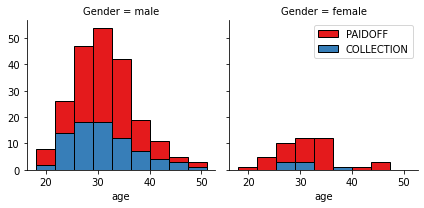

In [9]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction

### Lets look at the day of the week people get the loan 

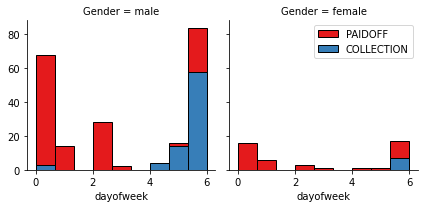

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4 

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Lets convert male to 0 and female to 1:


In [13]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding  
#### How about education?

In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Feature befor One Hot Encoding

In [15]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame 

In [16]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature selection

Lets defind feature sets, X:

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data 

Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [19]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification 

Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:
- K Nearest Neighbor(KNN)
- Decision Tree
- Support Vector Machine
- Logistic Regression



__ Notice:__ 
- You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
- You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
- You should include the code of the algorithm in the following cells.

# K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.  
**warning:** You should not use the __loan_test.csv__ for finding the best k, however, you can split your train_loan.csv into train and test to find the best __k__.

In [20]:
#Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score, jaccard_score
from sklearn.metrics import log_loss
import math


In [21]:
#Split the data into train and test set
#----------------------------------------
# Note: Try with different ratio of train and test data to find the best split
x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.25, random_state = 4)

print("Train dataset size: ",  x_train.shape, y_train.shape)
print("Test dataset size: ", x_test.shape, y_test.shape)

# sqrt of data points in training set is set as K value. Let us check the value - just curious
print("Square root of number of data points in train feature set :", math.sqrt(x_train.shape[0]))

Train dataset size:  (259, 8) (259,)
Test dataset size:  (87, 8) (87,)
Square root of number of data points in train feature set : 16.09347693943108


In [22]:
#Train  the KNN model
#--------------------

#Find the best K value
#Let us test through K values from 1 to 10 and find out the best one
kvals=20

#Let us use accuracy_score to calculate the accuracy of model
#Initialize accuracy array
accuracy = np.zeros((kvals-1))

#Loop through all values of k from 1 to 10
for n in range(1,kvals):
    
    #fit the model
    kneigh = KNeighborsClassifier(n_neighbors=n).fit( x_train, y_train)
    
    #predict test target
    yhat = kneigh.predict(x_test)
    
    #Find the accuracy
    accuracy[n-1] =  round( metrics.accuracy_score(y_test, yhat), 4)
    #Find f1 score and Jaccard score too
    f1 = f1_score(y_test, yhat, pos_label = 'PAIDOFF' )
    jacc = jaccard_score ( y_test, yhat, pos_label = 'PAIDOFF')
    print(" k = ",  n, '  accuracy :', accuracy[n-1], '  F1score :', f1, '   Jaccard :', jacc )
 
print("Maximum accuracy :", accuracy.max())


 k =  1   accuracy : 0.7356   F1score : 0.8244274809160305    Jaccard : 0.7012987012987013
 k =  2   accuracy : 0.7126   F1score : 0.7826086956521738    Jaccard : 0.6428571428571429
 k =  3   accuracy : 0.7586   F1score : 0.8372093023255814    Jaccard : 0.72
 k =  4   accuracy : 0.7356   F1score : 0.8067226890756303    Jaccard : 0.676056338028169
 k =  5   accuracy : 0.7931   F1score : 0.8615384615384615    Jaccard : 0.7567567567567568
 k =  6   accuracy : 0.7816   F1score : 0.8527131782945736    Jaccard : 0.7432432432432432
 k =  7   accuracy : 0.7931   F1score : 0.8714285714285714    Jaccard : 0.7721518987341772
 k =  8   accuracy : 0.7816   F1score : 0.8549618320610687    Jaccard : 0.7466666666666667
 k =  9   accuracy : 0.7701   F1score : 0.8550724637681159    Jaccard : 0.7468354430379747
 k =  10   accuracy : 0.7126   F1score : 0.8062015503875969    Jaccard : 0.6753246753246753
 k =  11   accuracy : 0.7816   F1score : 0.8652482269503546    Jaccard : 0.7625
 k =  12   accuracy : 0.

In [23]:
# ********** From the above metrics we conclude k = 7 is best k value ***********

In [24]:
#Let us repeat the model evaluation with few features removed
#drop 'terms'
Xk=Feature.copy()
Xk.drop(['terms'], axis=1,inplace=True)
Xk= preprocessing.StandardScaler().fit(Xk).transform(Xk)

xk_train,xk_test,yk_train,yk_test = train_test_split(Xk, y, test_size=0.25, random_state = 4)


In [25]:
kvals=10
accuracy = np.zeros((kvals-1))
for n in range(1,kvals):
    myneigh = KNeighborsClassifier(n_neighbors=n).fit( xk_train, yk_train)
    yhatk = myneigh.predict(xk_test)
    accuracy[n-1] =  round( metrics.accuracy_score(yk_test, yhatk), 4)
    print(accuracy[n-1], " k = ",  n)
print("Maximum accuracy :", accuracy.max())


0.7471  k =  1
0.7241  k =  2
0.7471  k =  3
0.6667  k =  4
0.7701  k =  5
0.7241  k =  6
0.8046  k =  7
0.7586  k =  8
0.7816  k =  9
Maximum accuracy : 0.8046


In [26]:
#Let us check by dropping principal

Xk=Feature.copy()
Xk.drop(['Principal'], axis=1, inplace = True)
Xk= preprocessing.StandardScaler().fit(Xk).transform(Xk)

xk_train, xk_test, yk_train, yk_test = train_test_split(Xk, y, test_size=0.25, random_state = 4)

kvals=10
accuracy = np.zeros((kvals-1))
for n in range(1,kvals):
    myneigh = KNeighborsClassifier(n_neighbors=n).fit( xk_train, yk_train)
    yhatk = myneigh.predict(xk_test)
    accuracy[n-1] =  round( metrics.accuracy_score(yk_test, yhatk), 4)
    print(accuracy[n-1], " k = ",  n)
print("Maximum accuracy :", accuracy.max())


0.7356  k =  1
0.6667  k =  2
0.7701  k =  3
0.7701  k =  4
0.7816  k =  5
0.7816  k =  6
0.7816  k =  7
0.8046  k =  8
0.7931  k =  9
Maximum accuracy : 0.8046


In [27]:

#Let us check by dropping both terms and principal

Xk=Feature.copy()
Xk.drop(['Principal','terms'], axis=1, inplace = True)
Xk= preprocessing.StandardScaler().fit(Xk).transform(Xk)

xk_train, xk_test, yk_train, yk_test = train_test_split(Xk, y, test_size=0.25, random_state = 4)

kvals=10
accuracy = np.zeros((kvals-1))
for n in range(1,kvals):
    myneigh = KNeighborsClassifier(n_neighbors=n).fit( xk_train, yk_train)
    yhatk = myneigh.predict(xk_test)
    accuracy[n-1] =  round( metrics.accuracy_score(yk_test, yhatk), 4)
    print(accuracy[n-1], " k = ",  n)
print("Maximum accuracy :", accuracy.max())
xk_train.shape

0.7356  k =  1
0.6437  k =  2
0.7241  k =  3
0.7356  k =  4
0.7586  k =  5
0.7586  k =  6
0.7471  k =  7
0.7471  k =  8
0.7701  k =  9
Maximum accuracy : 0.7701


(259, 6)

In [28]:
# Note:
#1. We notice dropping either terms or principalimproves the model whereas dropping both decreases the efficiency ********
#2. Removing any other feature decreases the accuracy
# the points 1 and 2 holdss true only for random_state=4 and test_size=.25 with this dataset. 
#3. Accuracy and hence the k value differs for different test_size!
#4. Accuracy and hence the k value differs for different random_state!

# The K value is concluded as 7 based on accuracy score , f1 score and jaccard score


In [29]:
#Final Model :
kneigh = KNeighborsClassifier(n_neighbors= 7 ).fit( x_train, y_train)
knnaccu =  round( metrics.accuracy_score(y_test, kneigh.predict(x_test)), 4)
      
print(" ***** Best k value (with test_size=0.25) was k = 7 with accuracy = ",knnaccu, " for the selected random_state *********")

 ***** Best k value (with test_size=0.25) was k = 7 with accuracy =  0.7931  for the selected random_state *********


# Decision Tree

In [30]:
#Train the decision tree model using scikit learn library
#-------------------------------------------------------

#using criterian as 'entrophy' to view the information gain
decitree = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5) 
decitree.fit(x_train,y_train)

#using criterian as 'entrophy' to view the information gain
#decitree = DecisionTreeClassifier() 
#decitree.fit(x_train,y_train)


DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [31]:
#Evaluation
#--------------

#predict loan default values
yhat = decitree.predict(x_test)

#accuracy
print("Decision tree model accuracy : ", metrics.accuracy_score(y_test,yhat))

Decision tree model accuracy :  0.735632183908046


# Support Vector Machine

In [32]:
#Train the model
svmmodel = svm.SVC(kernel='rbf')
svmmodel.fit(x_train,y_train)


SVC()

In [33]:
#Evaluation
#svmmodel = svm.SVC(kernel='linear')
#svmmodel.fit(x_train,y_train)

#predict yhat
yhat = svmmodel.predict(x_test)

#accuracy
svmacc = metrics.accuracy_score(y_test,yhat)

In [34]:
print("SVM model Accuracy : ", svmacc)

SVM model Accuracy :  0.7471264367816092


# Logistic Regression

In [35]:
#Train model
#Use various Regularization parameter and Solvers to find the best model 
lrmodel=LogisticRegression(C = 0.02, solver='liblinear')
lrmodel.fit(x_train,y_train)

LogisticRegression(C=0.02, solver='liblinear')

In [36]:
#Evaluation
#With C=0.3 or C=0.4 the model gives best accuracy
lrmodel=LogisticRegression(C = 0.4, solver='newton-cg')
lrmodel.fit(x_train,y_train)

#Predict yhat 
yhat = lrmodel.predict(x_test)
#Accuracy
lraccu = metrics.accuracy_score(y_test,yhat)
print("Logistic Regression model accuracy : ", lraccu)

Logistic Regression model accuracy :  0.7471264367816092


In [37]:
#predict probability
prob = lrmodel.predict_proba(x_test)
prob[0:5]

array([[0.47230212, 0.52769788],
       [0.3597707 , 0.6402293 ],
       [0.0338513 , 0.9661487 ],
       [0.0470362 , 0.9529638 ],
       [0.03394124, 0.96605876]])

# Model Evaluation using Test set

In [38]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-04-28 09:46:07--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-04-28 09:46:08 (186 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation 

In [39]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [40]:
#DATA CLEANING

In [41]:
#convert date columns
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])


In [42]:
#Data  visualization and Pre processing
#---------------------------------------

test_df['loan_status'].value_counts()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64

In [43]:
test_df['Gender'].value_counts(())

male      43
female    11
Name: Gender, dtype: int64

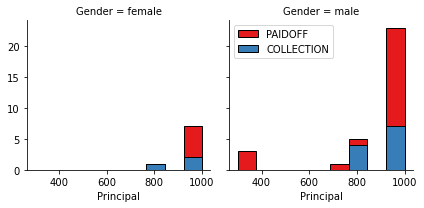

In [44]:
#visualize the data based on gender

#Does principal value has anything to do with loan-status?
bins = np.linspace(test_df.Principal.min(), test_df.Principal.max(), 10)
g = sns.FacetGrid(test_df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()


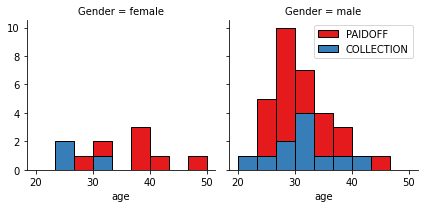

In [45]:
#Lets see how it is distributed for age

bins= np.linspace(test_df.age.min(), test_df.age.max(), 10)
graph = sns.FacetGrid(test_df, col='Gender', hue = 'loan_status', palette = 'Set1', col_wrap = 2)
graph.map(plt.hist, 'age', bins=bins, ec = 'k')
graph.axes[-1].legend()
plt.show()

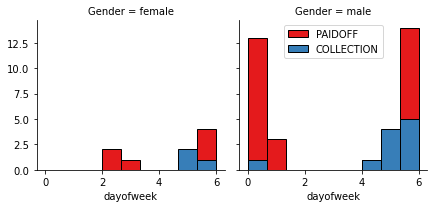

In [46]:
#with the day of getting loan
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek

bins= np.linspace(test_df.dayofweek.min(), test_df.dayofweek.max(), 10)
graph = sns.FacetGrid(test_df, col='Gender', hue = 'loan_status', palette = 'Set1', col_wrap = 2)
graph.map(plt.hist, 'dayofweek', bins=bins, ec = 'k')
graph.axes[-1].legend()
plt.show()

In [47]:
#Findings: *From the above graphs we see the test set is similar to train set in all characteristics

#Add a column called 'weekend' as a feature
test_df['weekend'] = test_df['dayofweek'].apply (lambda x : 1 if (x>3) else 0)
#conver gender to binary
test_df['Gender'].replace (to_replace = ['male','female'], value = [0,1], inplace = True)

test_df.head(5)

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [48]:
#See if there is gender wise notable difference 
test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64

In [49]:
#Education
test_df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64

In [50]:
#'master or above' and  'Bechalor' group has no defaulters. we can remove these two from feature set
# but however since our training set has 8 cols we cannot remove 'bechalor' here

#Let us build our test feature set
FeatureTest = test_df[['Principal','Gender','age', 'terms', 'weekend']]

FeatureTest.head()
# convert education to binary using one hot encoding and append to feature
FeatureTest = pd.concat([FeatureTest, pd.get_dummies(test_df['education'])], axis = 1)
FeatureTest.drop('Master or Above', axis = 1, inplace = True)
FeatureTest.head()


,Principal,Gender,age,terms,weekend,Bechalor,High School or Below,college
0,1000,1,50,30,0,1,0,0
1,300,0,35,7,1,0,0,0
2,1000,1,43,30,1,0,1,0
3,1000,0,26,30,1,0,0,1
4,800,0,29,15,1,1,0,0


In [51]:
#Feature set
tX = FeatureTest
tX.head()

,Principal,Gender,age,terms,weekend,Bechalor,High School or Below,college
0,1000,1,50,30,0,1,0,0
1,300,0,35,7,1,0,0,0
2,1000,1,43,30,1,0,1,0
3,1000,0,26,30,1,0,0,1
4,800,0,29,15,1,1,0,0


In [52]:
#Normalize feature
tX=preprocessing.StandardScaler().fit(tX).transform(tX)
tX[0:5]

array([[ 0.49362588,  1.97714211,  3.05981865,  0.92844966, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -0.50578054,  0.53336288, -1.70427745,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  1.97714211,  1.88080596,  0.92844966,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588, -0.50578054, -0.98251057,  0.92844966,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.50578054, -0.47721942, -0.78854628,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [53]:
#Target value
ty=test_df['loan_status'].values
ty

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION', 'COLLECTION', 'COLLECTION', 'COLLECTION',
       'COLLECTION'], dtype=object)

In [54]:
#pip install tabulate

In [55]:
# ++++++++++++++++++++ Evaluation Report ++++++++++++++++++++
from tabulate import tabulate

#Print the models using tabulate
models = [[repr(kneigh)], [str(decitree)], [repr(svmmodel)], [repr(lrmodel)]]
mtable = tabulate(models, ['Models'], tablefmt = 'fancy_grid', showindex='always')
print (mtable)

╒════╤══════════════════════════════════════════════════════════╕
│    │ Models                                                   │
╞════╪══════════════════════════════════════════════════════════╡
│  0 │ KNeighborsClassifier(n_neighbors=7)                      │
├────┼──────────────────────────────────────────────────────────┤
│  1 │ DecisionTreeClassifier(criterion='entropy', max_depth=5) │
├────┼──────────────────────────────────────────────────────────┤
│  2 │ SVC()                                                    │
├────┼──────────────────────────────────────────────────────────┤
│  3 │ LogisticRegression(C=0.4, solver='newton-cg')            │
╘════╧══════════════════════════════════════════════════════════╛


In [56]:
tX.shape

(54, 8)

# Report
You should be able to report the accuracy of the built model using different evaluation metrics:

| Algorithm          | Jaccard | F1-score | LogLoss |
|--------------------|---------|----------|---------|
| KNN                | ?       | ?        | NA      |
| Decision Tree      | ?       | ?        | NA      |
| SVM                | ?       | ?        | NA      |
| LogisticRegression | ?       | ?        | ?       |

In [60]:
print(f1_score(ty, kneigh.predict(tX), average='weighted'))
print(jaccard_score(ty, kneigh.predict(tX), average='weighted'))


0.6871008939974457
0.5660856935366739


In [57]:
#KNN Model
knnf1 = f1_score(ty, kneigh.predict(tX), pos_label = 'PAIDOFF')
knnjacc = jaccard_score(ty, kneigh.predict(tX), pos_label = 'PAIDOFF')

#Decison tree 
decif1 = f1_score(ty, decitree.predict(tX), pos_label = 'PAIDOFF')
decijacc = jaccard_score(ty, decitree.predict(tX), pos_label = 'PAIDOFF')

#SVM Model
svmf1 = f1_score(ty, svmmodel.predict(tX), pos_label = 'PAIDOFF')
svmjacc = jaccard_score(ty, svmmodel.predict(tX), pos_label = 'PAIDOFF')

#Logistic rgeression classification
lrf1 = f1_score(ty, lrmodel.predict(tX), pos_label = 'PAIDOFF')
lrjacc = jaccard_score(ty, lrmodel.predict(tX), pos_label = 'PAIDOFF')
#Find Logloss
lrlogloss = log_loss(ty, lrmodel.predict_proba(tX))

#Form a list to tabulate
evalmetrics = [['KNN', knnjacc, knnf1,'NA'], ['Decision Tree', decijacc, decif1, 'NA'], 
               ['SVM', svmjacc, svmf1, 'NA'], ['Logistic Regression', lrjacc, lrf1, lrlogloss]] 
#Print the report
headers = ['Algorithm', 'Jaccard', 'F1-Score', 'LogLoss']

Report1 = tabulate(evalmetrics, headers, tablefmt = 'fancy_grid')
print("\n For loan_status = 'PAIDOFF' \n")
print(Report1)


 For loan_status = 'PAIDOFF' 

╒═════════════════════╤═══════════╤════════════╤═════════════════════╕
│ Algorithm           │   Jaccard │   F1-Score │ LogLoss             │
╞═════════════════════╪═══════════╪════════════╪═════════════════════╡
│ KNN                 │  0.705882 │   0.827586 │ NA                  │
├─────────────────────┼───────────┼────────────┼─────────────────────┤
│ Decision Tree       │  0.754717 │   0.860215 │ NA                  │
├─────────────────────┼───────────┼────────────┼─────────────────────┤
│ SVM                 │  0.740741 │   0.851064 │ NA                  │
├─────────────────────┼───────────┼────────────┼─────────────────────┤
│ Logistic Regression │  0.730769 │   0.844444 │ 0.49989001256074944 │
╘═════════════════════╧═══════════╧════════════╧═════════════════════╛
